<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/utterance_generation/Utterance_Generation_with_Beam_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 22 15:07 .
drwxr-xr-x 4 root root 4.0K Jun 22 15:07 ..
-rw-r--r-- 1 root root 5.6M Jun 22 15:07 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 22 15:07 original
-rw-r--r-- 1 root root  49M Jun 22 15:07 test.tsv
-rw-r--r-- 1 root root  50M Jun 22 15:07 train.tsv


In [83]:
import time
import math
import random
import pandas as pd
import numpy as np
import spacy
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [7]:
len(train_df), len(valid_df)

(363192, 40372)

Text(0.5, 0, 'Train data distribution')

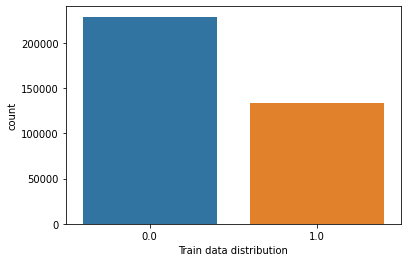

In [8]:
sns.countplot(train_df['is_duplicate'])
plt.xlabel('Train data distribution')

Text(0.5, 0, 'Valid data distribution')

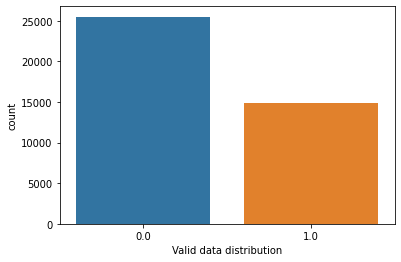

In [9]:
sns.countplot(valid_df['is_duplicate'])
plt.xlabel('Valid data distribution')

In [10]:
train_data = train_df[train_df['is_duplicate'] == 1]
valid_data = valid_df[valid_df['is_duplicate'] == 1]

In [11]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
7,106969,147570,787.0,What is the best self help book you have read?...,What are the top self help books I should read?,1.0
11,233239,71243,177376.0,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...,1.0
13,11568,22332,22333.0,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?,1.0


In [12]:
len(train_data), len(valid_data)

(134141, 14857)

In [13]:
train_data = train_data[['question1', 'question2']]
valid_data = valid_data[['question1', 'question2']]

In [14]:
train_data.head()

,question1,question2
1,How do I control my horny emotions?,How do you control your horniness?
3,What can one do after MBBS?,What do i do after my MBBS ?
7,What is the best self help book you have read?...,What are the top self help books I should read?
11,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...
13,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?


In [15]:
sample_train_data = train_data.sample(50000)
sample_valid_data = valid_data.sample(5000)

In [16]:
sample_train_data.to_csv('train_ds.csv')
sample_valid_data.to_csv('valid_ds.csv')

In [17]:
!ls -lah

total 6.1M
drwxr-xr-x 1 root root 4.0K Jun 22 15:07 .
drwxr-xr-x 1 root root 4.0K Jun 22 15:02 ..
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 .config
drwxr-xr-x 4 root root 4.0K Jun 22 15:07 glue_data
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root 5.5M Jun 22 15:07 train_ds.csv
-rw-r--r-- 1 root root 558K Jun 22 15:07 valid_ds.csv


In [18]:
tokenizer = data.get_tokenizer('spacy')
TEXT = data.Field(tokenize=tokenizer, lower=True, init_token='<sos>', eos_token='<eos>', include_lengths=True)

In [19]:
fields = [(None, None), ("source", TEXT), ("target", TEXT)]

train_dataset, valid_dataset = data.TabularDataset.splits(path='.',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=fields)

In [20]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")

Number of training examples: 50000
Number of validation examples: 5000


In [21]:
print(vars(train_dataset.examples[1]))

{'source': ['what', 'are', 'complex', 'networks', '?'], 'target': ['what', 'defines', 'a', 'complex', 'network', '?']}


In [22]:
TEXT.build_vocab(train_dataset, min_freq=5)

In [23]:
print(f"Number of tokens in vocabulary: {len(TEXT.vocab)}")

Number of tokens in vocabulary: 8130


In [24]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.source),
    sort_within_batch=True,
    device=device
)

In [25]:
# sample checking
temp = next(iter(train_iterator))
temp_source, temp_source_lengths = temp.source
temp_target, temp_target_lengths = temp.target
temp_source.shape, temp_source_lengths.shape, temp_target.shape, temp_target_lengths.shape

(torch.Size([9, 64]), torch.Size([64]), torch.Size([22, 64]), torch.Size([64]))

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, bidirectional=True, num_layers=n_layers, dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths):
        # src => [seq_len, batch_size]
        # src_lengths => [batch_size]

        embedded = self.dropout(self.embedding(src))
        # embedded => [seq_len, batch_size, hidden_dim]

        pack_padded_sequences = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)
        packed_outputs, (hidden, cell) = self.rnn(pack_padded_sequences)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs => [seq_len, batch_size, hidden_dim * 2]
        # hidden, cell => [num_layers * num_dir, batch_size, hidden_dim]

        hidden = hidden.view(self.n_layers, 2,  -1, self.hidden_dim)
        cell = cell.view(self.n_layers, 2,  -1, self.hidden_dim)
        # hidden, cell => [num_layers, num_dir, batch_size, hidden_dim]

        final_forward_hidden = hidden[:, 0, :, :]
        final_backward_hidden = hidden[:, 1, :, :]
        # final_hiddens => [num_layers, batch_size, hidden_dim]

        final_forward_cell = cell[:, 0, :, :]
        final_backward_cell = cell[:, 1, :, :]
        # final_cells => [num_layers, batch_size, hidden_dim]

        combined_hidden = torch.cat((final_forward_hidden, final_backward_hidden), dim=2)
        combined_cell = torch.cat((final_forward_cell, final_backward_cell), dim=2)
        # combined_hidden, combined_cell => [num_layers, batch_size, hidden_dim * 2]

        decoder_initial_hidden = self.fc(combined_hidden)
        decoder_initial_cell = self.fc(combined_cell)
        # decoder_initial_states => [num_layers, batch_size, hidden_dim]

        return outputs, decoder_initial_hidden, decoder_initial_cell

In [27]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, pad_idx):
        super().__init__()

        self.pad_idx = pad_idx

        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden => [batch_size, hidden_dim]
        # encoder_outputs => [seq_len, batch_size, hidden_dim * 2]
        # mask => [batch_size, seq_len]

        batch_size = encoder_outputs.shape[1]
        seq_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # hidden => [batch_size, seq_len, hidden_dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs => [batch_size, seq_len, hidden_dim * 2]

        hidden_energy = self.w1(hidden)
        # hidden_energy => [batch_size, seq_len, hidden_dim]

        encoder_energy = self.w2(encoder_outputs)
        # encoder_energy => [batch_size, seq_len, hidden_dim]

        combined_energy = hidden_energy + encoder_energy
        # combined_energy => [batch_size, seq_len, hidden_dim]

        energy = self.v(torch.tanh(combined_energy)).squeeze(2)
        # energy => [batch_size, seq_len]

        if mask is not None:
            energy = energy.masked_fill(mask == self.pad_idx, -1e10)
            # energy => [batch_size, seq_len]

        return F.softmax(energy, dim=1)

In [28]:
class Decoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, attn, dropout):
        super().__init__()

        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.attn = attn
        self.fc = nn.Linear(emb_dim + hidden_dim * 3, input_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, hidden, cell, encoder_outputs, mask):
        # trg => [batch_size]
        # hidden, cell => [num_layers, batch_size, hidden_dim]
        # encoder_outputs => [seq_len, batch_size, hidden_dim * 2]
        # mask => [batch_size, seq_len]

        embedded = self.dropout(trg)
        # embedded => [1, batch_size, emb_dim

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output => [1, batch_size, hidden_dim]
        # hidden, cell => [num_layers, batch_size, hidden_dim]

        attention = self.attn(output.squeeze(0), encoder_outputs, mask)
        # attention => [batch_size, seq_len]

        attention = attention.unsqueeze(1)
        # attention => [batch_size, 1, seq_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs => [batch_size, seq_len, hidden_dim * 2]

        weighted = torch.bmm(attention, encoder_outputs)
        # attention       => [batch_size, 1, seq_len]
        # encoder_outputs => [batch_size, seq_len, hidden_dim * 2]
        # weighted        => [batch_size, 1, hidden_dim * 2]

        weighted = weighted.permute(1, 0, 2)
        # weighted => [1, batch_size, hidden_dim * 2]

        combined_out_input = torch.cat((output, weighted, embedded), dim=2)
        # combined_out_input => [1, batch_size, hidden_dim * 3 + emb_dim]

        combined_out_input = combined_out_input.squeeze(0)
        combined_out_input = self.dropout(combined_out_input)
        # combined_out_input => [batch_size, hidden_dim * 3 + emb_dim]

        logits = self.fc(combined_out_input)
        # logits => [batch_size, output_dim]
        
        return logits, hidden, cell, attention.squeeze(1)

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx
    
    def make_mask(self, src):
        # src => [seq_len, batch_size]

        mask = (src == self.pad_idx)
        mask = mask.transpose(1, 0)
        # mask => [batch_size, seq_len]

        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src => [seq_len, batch_size]
        # trg => [trg_len, batch_size]

        src_mask = self.make_mask(src)
        # src_mask => [batch_size, seq_len]

        encoder_outputs, hidden, cell = self.encoder(src, src_len)
        # encoder_outputs => [seq_len, batch_size, hidden_dim * 2]
        # hidden, cell => [num_layers, batch_size, hidden_dim]

        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        output_dim = self.decoder.input_dim

        outputs = torch.zeros(trg_len, batch_size, output_dim).to(self.device)
        # outputs => [trg_len, batch_size, output_dim]

        dec_inp = trg[0, :]

        for t in range(1, trg_len):
            dec_emb = self.encoder.embedding(dec_inp.unsqueeze(0))
            # dec_emb => [1, batch_size, emb_dim]

            output, hidden, cell, _ = self.decoder(dec_emb, hidden, cell, encoder_outputs, src_mask)
            
            # store the output
            outputs[t] = output

            # to do teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the top prediction
            top1 = output.argmax(1)
            
            # next input to decoder
            dec_inp = trg[t] if teacher_force else top1
        
        return outputs

In [30]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
INPUT_DIM = len(TEXT.vocab)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
attn = Attention(HID_DIM, PAD_IDX)
dec = Decoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, attn, DROPOUT)
model = Seq2Seq(enc, dec, device, PAD_IDX).to(device)

In [31]:

def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8130, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attn): Attention(
      (w1): Linear(in_features=512, out_features=512, bias=True)
      (w2): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1792, out_features=8130, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 31102914 trainable parameters


In [33]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [34]:
def train(model, iterator, criterion, optimizer, clip):
    epoch_loss = 0

    # keep the model in train mode
    model.train()

    # iterate over train data
    for i, batch in enumerate(iterator):
        src, src_len = batch.source
        trg, _ = batch.target
        # src => [seq_len, batch_size]
        # src_len => [batch_size]
        # trg => [seq_len, batch_size]

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(src, src_len, trg)

        # reshaping the output to make it compatible to cal. loss
        # can also do without reshaping
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        # backward pass
        loss.backward()

        # gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update the parameters of the model
        optimizer.step()

        # update the loss
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    
    # keep the model in eval mode
    model.eval()
    
    # do not calculate gradients
    with torch.no_grad():

        # iterate over the data
        for batch in iterator:
            src, src_len = batch.source
            trg, _ = batch.target
            # src => [seq_len, batch_size]
            # src_len => [batch_size]
            # trg => [seq_len, batch_size]

            # forward pass
            # make sure the teacher_forcing_ratio is 0 in eval
            output = model(src, src_len, trg, 0)

            # reshaping for loss calculation
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # loss
            loss = criterion(output, trg)

            # update loss
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [37]:
N_EPOCHS = 8
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f"Epoch {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} |")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f} |")

Epoch 1 | Time: 5m 33.4158935546875s
	Train Loss: 4.442 | Train PPL:  84.930 |
	Valid Loss: 4.110 | Valid PPL:  60.977 |
Epoch 2 | Time: 5m 32.07571077346802s
	Train Loss: 3.475 | Train PPL:  32.286 |
	Valid Loss: 3.762 | Valid PPL:  43.015 |
Epoch 3 | Time: 5m 32.077293157577515s
	Train Loss: 3.057 | Train PPL:  21.266 |
	Valid Loss: 3.557 | Valid PPL:  35.045 |
Epoch 4 | Time: 5m 31.61773920059204s
	Train Loss: 2.809 | Train PPL:  16.593 |
	Valid Loss: 3.453 | Valid PPL:  31.608 |
Epoch 5 | Time: 5m 31.004390954971313s
	Train Loss: 2.613 | Train PPL:  13.639 |
	Valid Loss: 3.501 | Valid PPL:  33.132 |
Epoch 6 | Time: 5m 31.26005530357361s
	Train Loss: 2.465 | Train PPL:  11.766 |
	Valid Loss: 3.446 | Valid PPL:  31.378 |
Epoch 7 | Time: 5m 30.851324319839478s
	Train Loss: 2.369 | Train PPL:  10.689 |
	Valid Loss: 3.432 | Valid PPL:  30.935 |
Epoch 8 | Time: 5m 29.957483530044556s
	Train Loss: 2.279 | Train PPL:   9.763 |
	Valid Loss: 3.442 | Valid PPL:  31.257 |


In [38]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [39]:
def generate_utterance_greedy(sentence, text_field, model, device, max_len=50):
    model.eval()

    # tokenization        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [text_field.init_token] + tokens + [text_field.eos_token]

    # convert the tokens to ids  
    src_indexes = [text_field.vocab.stoi[token] for token in tokens]
    
    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # src_tensor => [seq_len, 1]
    
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    # src_len => [1]

    # encode the input sentence
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # mask of the input sentence
    mask = model.make_mask(src_tensor)

    # the starting input to decoder is always <sos>
    trg_indexes = [text_field.vocab.stoi[text_field.init_token]]

    # to store attentions 
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    # attentions => [max_len, 1, src_len]

    # decode upto a length of max_len
    for i in range(max_len):

        # convert the decoder input to tensor format
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        # trg input embedding
        trg_embed = model.encoder.embedding(trg_tensor.unsqueeze(1))
        # trg_embed => [1, 1, emb_dim]

        # decode the input
        with torch.no_grad():
            output, hidden, cell, attention = model.decoder(trg_embed, hidden, cell, encoder_outputs, mask)
        
        # store the attention
        attentions[i] = attention

        # get the predicted token by considering the token with highest score
        pred_token = output.argmax(1).item()
        
        # add to predicted tokens
        trg_indexes.append(pred_token)

        # if the predicted token is <eos> means stop the decoding
        if pred_token == text_field.vocab.stoi[text_field.eos_token]:
            break

    # convert the predicted token ids to words
    trg_tokens = [text_field.vocab.itos[i] for i in trg_indexes]
    
    return tokens[1:], trg_tokens[1:], attentions[:len(trg_tokens)-1]

#### This is not a optimal way to implement Beam Search. I implemented in a naive way in-order to understand it better. Please suggest ways to improve this by raising an issue [here](https://github.com/graviraja/100-Days-of-NLP/issues)

In [111]:
def generate_utterance_beam(sentence, model, device, text_field, max_len=50, beam_size=3):
    model.eval()

    # tokenization        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [text_field.init_token] + tokens + [text_field.eos_token]

    # convert the tokens to ids  
    src_indexes = [text_field.vocab.stoi[token] for token in tokens]
    
    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # src_tensor => [seq_len, 1]

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    # src_len => [1]

    # encode the input sentence
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)
        # encoder_outputs => [src_len, 1, hidden_dim * 2]
        # hidden, cell => [num_layers, 1, hidden_dim]
    
    num_layers, _, hid_dim = list(hidden.size())

    # mask of the input sentence
    mask = model.make_mask(src_tensor)
    # [1, src_len]

    # the starting input to decoder is always <sos>
    initial_trg_indexes = [text_field.vocab.stoi[text_field.init_token]]

    # convert the decoder input to tensor format
    trg_tensor = torch.LongTensor([initial_trg_indexes[-1]]).to(device)
    
    # trg input embedding
    trg_embed = model.encoder.embedding(trg_tensor.unsqueeze(1))
    # trg_embed => [1, 1, emb_dim]

    # decode the input
    with torch.no_grad():
        output, hidden, cell, _ = model.decoder(trg_embed, hidden, cell, encoder_outputs, mask)

    # get the predicted token by considering the token with highest score
    pred_token = output.argmax(1).item()
    
    top_k_scores, top_k_indexes = output.topk(beam_size, 1, True, True)
    # top_k_scores => [1, beam_size]
    # top_k_indexes => [1, beam_size]

    top_k_indexes = top_k_indexes.squeeze().tolist()

    # the starting input to decoder is always <sos>
    trg_seq_indexes = []
    # trg_seq_indexes = list([[text_field.vocab.stoi[text_field.init_token]]] * beam_size)
    for i in range(beam_size):
        trg_seq_indexes.append([text_field.vocab.stoi[text_field.init_token], top_k_indexes[i]])
    # [[<sos>, inital_top1], [<sos>, initial_top2], [<sos>, initial_top3]]

    # replicate hidden states so that relevant ones can be used
    hidden_states = [hidden] * beam_size
    cell_states = [cell] * beam_size

    # scores after initial step
    scores = top_k_scores.squeeze()
    # [beam_size]
    completed_seqs = []
    eos_encountered = 0

    # decode upto a length of max_len
    for i in range(max_len-1):
        temp_sequences = []
        for index, each_seq in enumerate(trg_seq_indexes):
            # if the sequence already hits <eos> means then continue decoding the next sequence
            if each_seq[-1] == text_field.vocab.stoi[text_field.eos_token]:
                continue
            # convert the decoder input to tensor format
            trg_tensor = torch.LongTensor([each_seq[-1]]).to(device)
            
            # trg input embedding
            trg_embed = model.encoder.embedding(trg_tensor.unsqueeze(1))
            # trg_embed => [1, 1, emb_dim]

            # get the relevant hidden, cell states
            hidden = hidden_states[index].to(device)
            cell = cell_states[index].to(device)

            # decode the input
            with torch.no_grad():
                output, hidden, cell, _ = model.decoder(trg_embed, hidden, cell, encoder_outputs, mask)
                # output => [1, vocab_size]

            # update the hidden and cell states of the sequence accordingly
            hidden_states[index] = hidden
            cell_states[index] = cell

            # get the probability scores of the prediction
            prediction_scores = F.softmax(output, dim=1)

            top_k_scores, top_k_indexes = prediction_scores.topk(beam_size, 1, True, True)
            # top_k_scores => [1, beam_size]
            # top_k_indexes => [1, beam_size]

            top_k_scores = top_k_scores.squeeze()
            top_k_indexes = top_k_indexes.squeeze()
            # top_k_scores => [beam_size]
            # top_k_indexes => [beam_size]

            # length of the sequence
            length = len(each_seq)

            prev_seq_score = torch.tensor([scores[index]]).to(device)
            current_seq_score = (prev_seq_score * length) + top_k_scores
            # length penality
            current_seq_score = current_seq_score / (length + 1)
            # current_seq_score => [beam_size]

            for item in range(beam_size):
                temp_sequences.append([current_seq_score[item].item(), top_k_indexes[item].item(), hidden, cell])

        # order all candidates by score
        ordered = sorted(temp_sequences, key=lambda tup:tup[0], reverse=True)
        top_results = ordered[:beam_size-eos_encountered]

        temp_hidden = []
        temp_cell = []
        temp_scores = []
        temp_trg_indexes = []

        for idx, result in enumerate(top_results):
            seq_score = result[0]
            seq_token = result[1]
            hidden = result[2]
            cell = result[3]

            trg_seq_indexes[idx].append(seq_token)
            scores[idx] = seq_score
            hidden_states[idx] = hidden
            cell_states[idx] = cell

            if seq_token == text_field.vocab.stoi[text_field.eos_token]:
                eos_encountered += 1
                completed_seqs.append(trg_seq_indexes[idx])
            
            temp_scores.append(seq_score)
            temp_hidden.append(hidden)
            temp_cell.append(cell)

            temp_scores.append(seq_score)
            hidden_states.append(hidden)
            cell_states.append(cell)
            if seq_token != text_field.vocab.stoi[text_field.eos_token]:
                temp_trg_indexes.append(trg_seq_indexes[idx])
        trg_seq_indexes = temp_trg_indexes
        hidden_states = temp_hidden
        cell_states = temp_cell
        scores = temp_scores
        
        if eos_encountered == beam_size:
            break

    # convert the predicted token ids to words
    trg_tokens = [[text_field.vocab.itos[i] for i in seq] for seq in completed_seqs]
    return trg_tokens

In [112]:
example_idx = 55

src = vars(valid_dataset.examples[example_idx])['source']
trg = vars(valid_dataset.examples[example_idx])['target']
_, greedy_utterance, _ = generate_utterance_greedy(src, TEXT, model, device)

print(f'src = {src}')
print(f'trg = {trg}')
print(f'generated greedy utterance = {greedy_utterance}')
print(f'generated beam utterances:')
seq = generate_utterance_beam(src, model, device, TEXT)
for s in seq:
    print(s[1:-1])

src = ['which', 'book', 'would', 'you', 'recommend', 'to', 'improve', 'english', '?']
trg = ['what', 'are', 'the', 'books', 'to', 'improve', 'english', '?']
generated greedy utterance = ['what', 'are', 'the', 'best', 'books', 'to', 'learn', 'english', '?', '<eos>']
generated beam utterances:
['what', 'are', 'the', 'best', 'book', 'to', 'learn', 'english', '?']
['which', 'is', 'the', 'best', 'books', 'to', 'learn', 'english', '?']
['how', 'books', 'some', 'good', 'books', 'to', 'learn', 'english', '?']


In [114]:

src = "What can I do after engineering?"
tokens, greedy_utterance, _ = generate_utterance_greedy(src, TEXT, model, device)

print(f'src = {tokens}')
print(f'generated greedy utterance = {greedy_utterance}')
print(f'generated beam utterances:')
seq = generate_utterance_beam(src, model, device, TEXT)
for s in seq:
    print(s[1:-1])

src = ['what', 'can', 'i', 'do', 'after', 'engineering', '?', '<eos>']
generated greedy utterance = ['what', 'should', 'i', 'do', 'after', 'engineering', '?', '<eos>']
generated beam utterances:
['what', 'should', 'i', 'do', 'after', 'engineering', '?']
['how', 'can', 'i', 'do', 'after', 'engineering', '?']
['i', 'do', 'i', 'do', 'after', 'engineering', '?']
